In [6]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Datasets/2payments_balanced_smote+rund-10m.csv', low_memory = False)

In [7]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [37, 38]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [4]:
#bins amount
#transfers: 1M - 35.8775 / 2M - 37.3285 / 3M - 38.2194 / 4M - 38.818 / 5M - 39.3326 / gans - 26.3159 / imbalanced - 24.7233
#payments: 1M - 36.7452 / 2M - 38.2134 / 3M - 39.1709 / 4M - 39.8368 / 5M - 40.2234 / gans - 24.8089 / imbalanced - 22.5533

#bins accountbalance
#transfers: 1M - 37.0555 / 2M - 38.5003 / 3M - 39.4439 / 4M - 40.1224 / 5M - 40.627 / gans - 25.734 / imbalanced - 23.9742
#payments: 1M - 37.234 / 2M - 38.6645 / 3M - 39.651 / 4M - 40.2506 / 5M - 40.7402 / gans - 26.0935 / imbalanced - 20.7986

In [8]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [6]:
#interval that a word corresponds to
#values_map['red']

In [9]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [10]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [11]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [12]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [13]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [14]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [15]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [16]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [17]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [18]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [14]:
#get size of the corpus 
token_count = sum([len(sentence) for sentence in sentences_series])

print("This corpus contains {} tokens".format(token_count))

This corpus contains 133000 tokens


In [15]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences, sample, negative, alpha, min_alpha):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 2,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = sample,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = negative,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = alpha,  #initial learning rate 
        min_alpha = min_alpha,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 5, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

In [19]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1, fraud_probv
    
    return 0, nfraud_probv

In [20]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []
    predictions_prob = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction, curr_prob = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)
        predictions_prob.apped(curr_prob)

    return predictions

In [21]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [22]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [ ]:
#grid-search
import os
import mlflow
from mlflow import log_metric, log_param, log_artifact
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

#create a hyperparameters dictionary 
negative = [5, 10] #0 leads to not having the syn1neg property
alpha = [0.025, 0.035, 0.045] 
min_alpha = [0.0001, 0.001, 0.01, 0.1]  
sample = [0, 0.001, 0.01, 0.1]

#train the model 
i = 0
for n in negative:
    for a in alpha:
        for m in min_alpha: 
            for s in sample: 
                i+=1
                with mlflow.start_run(nested=True):
                    # Log params to mlflow
                    log_param("negative", n)
                    log_param("alpha", a)
                    log_param("min_alpha", m)
                    log_param("sample", s)

                    curr_model = training(sentences_series_np_train, sample = s, negative = n, alpha = a, min_alpha = m)

                    #metrics for each combination - train
                    prevs_train = predict(curr_model, sentences_series_np_train, verbose1 = False, verbose2 = False)
                    precision_train, recall_train, fscore_train, _ = precision_recall_fscore_support(y_train, prevs_train, average = 'micro')
                    mcc_train = matthews_corrcoef(y_train, prevs_train)
                    g_mean_train = geometric_mean_score(y_train, prevs_train, average = 'micro')
                    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, prevs_train).ravel()

                    log_param("precision_train", precision_train)
                    log_param("recall_train", recall_train)
                    log_param("f1_train", fscore_train)
                    log_param("mcc_train", mcc_train)
                    log_param("g_mean_train", g_mean_train)
                    log_param("tn_train", tn_train)
                    log_param("fp_train", fp_train)
                    log_param("fn_train", fn_train)
                    log_param("tp_train", tp_train)

                    #metrics for each combination - test
                    prevs_test = predict(curr_model, sentences_series_np_test, verbose1 = False, verbose2 = False)
                    precision_test, recall_test, fscore_test, _ = precision_recall_fscore_support(y_test, prevs_test, average = 'micro')
                    mcc_test = matthews_corrcoef(y_test, prevs_test)
                    g_mean_test = geometric_mean_score(y_test, prevs_test, average = 'micro')
                    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, prevs_test).ravel()

                    log_param("precision_test", precision_test)
                    log_param("recall_test", recall_test)
                    log_param("f1_test", fscore_test)
                    log_param("mcc_test", mcc_test)
                    log_param("g_mean_test", g_mean_test)
                    log_param("tn_test", tn_test)
                    log_param("fp_test", fp_test)
                    log_param("fn_test", fn_test)
                    log_param("tp_test", tp_test)


                    curr_model.save("trained_model.w2v")
                    log_artifact("trained_model.w2v")
                    os.remove("trained_model.w2v")

In [ ]:
#apply the prediction method for the train set
#predict(model, X_train_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values for the train set
#y_train

In [ ]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_train
prevs = predict(model, X_train_np.values, verbose1 = False, verbose2 = False, shouldBe = trs)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs,prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

In [ ]:
#apply the prediction method for the test set
#predict(model, X_test_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values of the test set
#set(y_test)

In [23]:
#load the ideal model
import gensim.models.word2vec as w2v

model = w2v.Word2Vec.load(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Notebooks/mlruns/0/a434d0ef7d614097885680fba8e15c9b/artifacts/trained_model.w2v')

Transaction: [9, 2, 19648, 19649, 0, 19650, 1, 88, 7, 43, 19651, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0004387545824897643
Non Fraud prob: 0.0004385460026128385
Transaction: [17, 2, 63, 198, 0, 204, 1, 54, 7, 19, 203, 6, 4, 18, 75, 22, 28, 3]
Fraud prob: 0.0014813945537528197
Non Fraud prob: 0.0014804783433421688
Transaction: [17, 2, 27, 375, 0, 184, 1, 21, 7, 48, 183, 6, 4, 5, 101, 26, 41, 3]
Fraud prob: 0.0025301503417237163
Non Fraud prob: 0.002528886107708464
Transaction: [9, 2, 25, 150, 0, 51, 1, 31, 7, 19, 120, 13, 11, 5, 34, 58, 20, 14]
Fraud prob: 0.003219727076006762
Non Fraud prob: 0.0032137887013365396
Transaction: [9, 2, 25, 17910, 0, 77, 1, 38, 7, 40, 79, 13, 11, 44, 34, 26, 20, 14]
Fraud prob: 0.0022295036189576307
Non Fraud prob: 0.0022246552263937586
Transaction: [17, 55, 53, 20568, 243, 20569, 1, 78, 8, 76, 20570, 6, 4, 18, 104, 26, 12, 3]
Fraud prob: 0.0004679127869309241
Non Fraud prob: 0.0004677989036423469
Transaction: [17, 2, 9485, 31600, 0, 31601, 1, 91, 8, 40, 3

Transaction: [15, 2, 14642, 14643, 0, 14644, 14645, 82, 7, 61, 14646, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006440637280320516
Non Fraud prob: 0.0006441798068408389
Transaction: [9, 2, 851, 24605, 0, 24606, 1, 46, 7, 19, 24607, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0015105378051885054
Non Fraud prob: 0.0015110185786397778
Transaction: [9, 2, 140, 15762, 74, 15763, 1, 62, 8, 33, 15764, 13, 11, 18, 154, 10, 49, 14]
Fraud prob: 0.000818778718894464
Non Fraud prob: 0.0008190732387447497
Transaction: [9, 2, 100, 24700, 0, 24701, 1, 46, 8, 95, 24702, 30, 42, 44, 167, 23, 57, 32]
Fraud prob: 0.0005702097914763726
Non Fraud prob: 0.0005702405669580912
Transaction: [15, 2, 166, 16940, 0, 16941, 1, 38, 8, 144, 16942, 6, 4, 80, 86, 23, 37, 3]
Fraud prob: 0.0005088722624009279
Non Fraud prob: 0.0005087712648332854
Transaction: [9, 2, 354, 478, 0, 22070, 1, 93, 7, 45, 143, 6, 4, 5, 90, 23, 41, 3]
Fraud prob: 0.000854034049098118
Non Fraud prob: 0.000854345743846352
Transaction: [209, 55, 53, 15028

Transaction: [9, 2, 25, 25262, 0, 51, 1, 31, 7, 19, 115, 13, 11, 5, 34, 52, 20, 14]
Fraud prob: 0.0032890410887690957
Non Fraud prob: 0.0032831027140988733
Transaction: [15, 112, 53, 108, 0, 178, 177, 73, 7, 95, 14509, 30, 85, 5, 105, 10, 12, 3]
Fraud prob: 0.0004920816433126101
Non Fraud prob: 0.0004903587911370205
Transaction: [15, 112, 53, 108, 0, 178, 177, 73, 7, 61, 19122, 30, 85, 5, 105, 10, 12, 3]
Fraud prob: 0.0004919347271764645
Non Fraud prob: 0.0004902118750008749
Transaction: [9, 2, 187, 3839, 0, 3840, 1, 31, 8, 61, 3841, 13, 11, 5, 121, 52, 57, 14]
Fraud prob: 0.0004919184848404257
Non Fraud prob: 0.0004918463400827022
Transaction: [17, 2, 27, 10797, 0, 233, 1, 68, 7, 96, 231, 72, 4, 5, 109, 29, 41, 3]
Fraud prob: 0.0012646269179389799
Non Fraud prob: 0.0012639428251281367
Transaction: [15, 2, 336, 30679, 0, 30680, 1, 67, 8, 61, 30681, 6, 4, 18, 167, 23, 57, 3]
Fraud prob: 0.0008512589865858899
Non Fraud prob: 0.000851280541610322
Transaction: [9, 2, 25, 22617, 0, 77, 1, 6

Transaction: [17, 2, 448, 12308, 0, 12309, 1, 46, 8, 96, 12310, 6, 4, 24, 125, 10, 28, 3]
Fraud prob: 0.000682858047184709
Non Fraud prob: 0.0006830835545770242
Transaction: [15, 2, 26910, 26911, 0, 26912, 1, 82, 7, 43, 26913, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.005439779962443936
Non Fraud prob: 0.005439575313403111
Transaction: [17, 2, 14986, 14987, 0, 186, 1, 83, 7, 45, 162, 64, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0007040283704535911
Non Fraud prob: 0.0007034522310258696
Transaction: [17, 2, 27, 32539, 0, 32540, 1, 21, 7, 60, 32541, 6, 4, 5, 16, 10, 28, 3]
Fraud prob: 0.0009082707255743117
Non Fraud prob: 0.0009085465207476773
Transaction: [15, 2, 457, 23301, 0, 454, 1, 89, 7, 43, 451, 64, 4, 24, 147, 23, 12, 3]
Fraud prob: 0.0006144195523809515
Non Fraud prob: 0.0006144727068893019
Transaction: [17, 112, 53, 108, 74, 1032, 1056, 88, 8, 71, 1078, 30, 42, 18, 163, 52, 41, 14]
Fraud prob: 0.0004988239525118843
Non Fraud prob: 0.0004988581240468193
Transaction: [15, 2, 20640, 30138, 0

Transaction: [15, 153, 532, 28896, 0, 28897, 1, 31, 8, 95, 28898, 6, 4, 24, 118, 10, 49, 3]
Fraud prob: 0.0005570764833180419
Non Fraud prob: 0.000557222730066087
Transaction: [9, 2, 25, 8377, 0, 77, 1, 102, 7, 43, 79, 13, 11, 5, 69, 10, 20, 14]
Fraud prob: 0.002200240492859551
Non Fraud prob: 0.002195392100295679
Transaction: [17, 2, 63, 198, 0, 247, 1, 54, 7, 40, 244, 64, 4, 5, 59, 23, 35, 3]
Fraud prob: 0.0013391785690372016
Non Fraud prob: 0.0013388424197954263
Transaction: [9, 36, 66, 25467, 0, 25468, 1, 65, 8, 43, 25469, 13, 11, 18, 106, 23, 49, 14]
Fraud prob: 0.00047999812613852555
Non Fraud prob: 0.0004798604722964228
Transaction: [9, 2, 221, 7223, 0, 811, 1, 62, 8, 40, 7232, 13, 11, 24, 34, 23, 20, 14]
Fraud prob: 0.0006203783875662339
Non Fraud prob: 0.0006205303459410061
Transaction: [9, 2, 25, 31464, 0, 51, 1, 31, 7, 19, 31465, 13, 11, 5, 16, 10, 20, 14]
Fraud prob: 0.0033787418232233413
Non Fraud prob: 0.003372803448553119
Transaction: [9, 2, 25, 12822, 0, 51, 1, 46, 7, 1

Transaction: [15, 2, 4915, 24915, 0, 24916, 1, 46, 8, 61, 24917, 64, 4, 44, 222, 29, 97, 3]
Fraud prob: 0.0018807458694141133
Non Fraud prob: 0.0018802897905629834
Transaction: [9, 2, 523, 31012, 0, 31013, 1, 21, 7, 19, 31014, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0009036203537107212
Non Fraud prob: 0.0009031850313476752
Transaction: [15, 2, 725, 11848, 0, 11849, 11850, 68, 7, 45, 11851, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.000418060851188784
Non Fraud prob: 0.0004178134904577746
Transaction: [9, 2, 25786, 25787, 0, 25788, 1, 62, 8, 107, 25789, 13, 11, 24, 142, 29, 57, 14]
Fraud prob: 0.0006491668318631127
Non Fraud prob: 0.0006493478449556278
Transaction: [9, 2, 25, 10537, 0, 77, 1, 65, 7, 43, 79, 13, 11, 5, 69, 10, 20, 14]
Fraud prob: 0.0021392372989818553
Non Fraud prob: 0.0021343889064179833
Transaction: [9, 2, 25, 508, 0, 77, 1, 65, 7, 103, 79, 6, 11, 87, 69, 23, 20, 3]
Fraud prob: 0.0021040543580284066
Non Fraud prob: 0.0021038039013774323
Transaction: [15, 2, 876, 1677, 0, 1678

Transaction: [9, 2, 473, 32710, 0, 32711, 1, 56, 8, 33, 32712, 30, 42, 80, 109, 22, 41, 32]
Fraud prob: 0.0006731768795020798
Non Fraud prob: 0.0006727365440042377
Transaction: [9, 2, 63, 14355, 0, 14356, 1, 31, 7, 103, 14337, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006655145456875289
Non Fraud prob: 0.0006656628806354092
Transaction: [15, 2, 63, 21631, 243, 21632, 1, 38, 8, 45, 21633, 72, 4, 24, 104, 26, 12, 3]
Fraud prob: 0.0013085436135611417
Non Fraud prob: 0.0013089548979792198
Transaction: [15, 2, 251, 5268, 0, 5269, 1, 99, 8, 103, 5270, 6, 4, 44, 122, 58, 37, 3]
Fraud prob: 0.0004374234727038129
Non Fraud prob: 0.0004372167882138456
Transaction: [9, 2, 272, 6698, 0, 6699, 1, 67, 8, 40, 6700, 13, 11, 18, 163, 22, 41, 14]
Fraud prob: 0.0005040908031332947
Non Fraud prob: 0.0005040780592935334
Transaction: [15, 2, 94, 12106, 0, 12107, 1, 68, 7, 47, 253, 6, 4, 5, 121, 22, 57, 3]
Fraud prob: 0.0005598413540610636
Non Fraud prob: 0.0005599331766461546
Transaction: [15, 112, 53, 108, 0,

Transaction: [9, 2, 30312, 30313, 0, 30314, 1, 54, 7, 45, 30315, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.008078664832964932
Non Fraud prob: 0.00807944464099819
Transaction: [17, 2, 18936, 18937, 0, 186, 1, 83, 7, 33, 162, 64, 4, 18, 16, 10, 12, 3]
Fraud prob: 0.0005303626509203241
Non Fraud prob: 0.0005304019592813347
Transaction: [9, 2, 25, 6912, 0, 51, 1, 31, 7, 19, 115, 13, 11, 18, 34, 52, 20, 14]
Fraud prob: 0.0031961982020535795
Non Fraud prob: 0.003190259827383357
Transaction: [17, 2, 278, 27300, 0, 15717, 1, 83, 8, 98, 27301, 30, 42, 44, 126, 10, 28, 32]
Fraud prob: 0.00043333330268069403
Non Fraud prob: 0.0004330626334194676
Transaction: [15, 2, 187, 20337, 0, 20338, 1, 46, 8, 61, 20339, 6, 85, 44, 106, 26, 49, 3]
Fraud prob: 0.0005229095792742555
Non Fraud prob: 0.0005229403674888999
Transaction: [15, 55, 84, 21576, 0, 21577, 1, 93, 8, 76, 21947, 72, 4, 44, 105, 22, 12, 3]
Fraud prob: 0.0005587779016877903
Non Fraud prob: 0.0005590110197317699
Transaction: [15, 2, 20859, 20858, 

Transaction: [9, 2, 27, 20472, 0, 20473, 1, 21, 7, 19, 20474, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0010705837275963859
Non Fraud prob: 0.0010709338066590135
Transaction: [17, 2, 27, 128, 0, 131, 1, 21, 7, 76, 130, 6, 4, 5, 59, 22, 35, 3]
Fraud prob: 0.0017998684214104454
Non Fraud prob: 0.0017973394877186532
Transaction: [15, 55, 84, 33040, 0, 33041, 1, 99, 8, 45, 33042, 6, 4, 24, 104, 23, 12, 3]
Fraud prob: 0.0018687479564505338
Non Fraud prob: 0.0018684440542529046
Transaction: [9, 2, 30728, 30729, 0, 30730, 30731, 82, 7, 33, 30732, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0007575334639113862
Non Fraud prob: 0.0007575594663649099
Transaction: [9, 36, 169, 23214, 0, 23215, 1, 38, 8, 61, 23216, 30, 42, 24, 90, 23, 41, 14]
Fraud prob: 0.0005304858032104676
Non Fraud prob: 0.0005305170388965053
Transaction: [9, 2, 156, 9108, 0, 9109, 1, 21, 7, 19, 9110, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0008114584938994085
Non Fraud prob: 0.0008117521406347805
Transaction: [9, 36, 66, 28938, 0, 28939, 

Transaction: [9, 2, 15861, 15885, 0, 15886, 1, 21, 7, 40, 15887, 6, 4, 5, 16, 10, 35, 3]
Fraud prob: 0.0005036590105191863
Non Fraud prob: 0.0005036630159338529
Transaction: [15, 2, 456, 29674, 0, 29675, 1, 65, 8, 103, 29676, 30, 85, 80, 59, 10, 35, 3]
Fraud prob: 0.0005590524542640196
Non Fraud prob: 0.0005590664077317342
Transaction: [9, 2, 29835, 29836, 0, 29837, 1, 68, 7, 76, 29838, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0013653361065735226
Non Fraud prob: 0.0013652465868290165
Transaction: [9, 2, 489, 14191, 0, 14192, 1, 65, 8, 397, 14193, 13, 11, 44, 34, 52, 20, 14]
Fraud prob: 0.0005718809347854403
Non Fraud prob: 0.0005719906162084953
Transaction: [17, 2, 563, 28995, 0, 28996, 28997, 386, 7, 208, 28998, 6, 4, 5, 16, 22, 12, 3]
Fraud prob: 0.0005135040066761576
Non Fraud prob: 0.0005135274061558448
Transaction: [15, 2, 20691, 20692, 0, 20693, 1, 68, 7, 19, 20694, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005419512408479932
Non Fraud prob: 0.000542009761375084
Transaction: [17, 2, 84

Transaction: [9, 36, 169, 30997, 0, 30998, 1, 67, 8, 43, 30999, 13, 11, 44, 109, 26, 41, 14]
Fraud prob: 0.0005329012037691427
Non Fraud prob: 0.0005327464459696785
Transaction: [9, 2, 611, 3819, 0, 3820, 1, 73, 8, 40, 3821, 13, 11, 24, 109, 23, 41, 14]
Fraud prob: 0.0004360715508937574
Non Fraud prob: 0.00043585003800217237
Transaction: [9, 2, 25, 191, 0, 51, 1, 46, 7, 19, 133, 13, 11, 5, 34, 22, 20, 14]
Fraud prob: 0.002937062724717776
Non Fraud prob: 0.0029311243500475537
Transaction: [15, 2, 389, 17987, 0, 17988, 17989, 68, 7, 45, 253, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.00044799322807875797
Non Fraud prob: 0.0004478661789448779
Transaction: [15, 36, 156, 8684, 0, 8686, 1, 62, 8, 144, 8687, 6, 4, 24, 159, 22, 49, 3]
Fraud prob: 0.0005905979937779193
Non Fraud prob: 0.0005908301477575151
Transaction: [17, 55, 53, 6900, 0, 6901, 1, 78, 8, 48, 6893, 6, 4, 24, 141, 26, 35, 3]
Fraud prob: 0.0004293816414246976
Non Fraud prob: 0.00042890402210105094
Transaction: [15, 295, 53, 108, 0, 3

Transaction: [9, 2, 25, 32605, 0, 51, 1, 31, 7, 19, 115, 13, 11, 5, 34, 52, 20, 14]
Fraud prob: 0.0032890410887690957
Non Fraud prob: 0.0032831027140988733
Transaction: [15, 2, 111, 18749, 0, 18750, 1, 78, 8, 47, 18751, 64, 4, 5, 123, 10, 50, 3]
Fraud prob: 0.0006685510452371091
Non Fraud prob: 0.0006687591630907264
Transaction: [17, 2, 63, 211, 0, 172, 1, 54, 7, 71, 217, 6, 4, 5, 114, 26, 37, 3]
Fraud prob: 0.0012935121565371597
Non Fraud prob: 0.0012921509049030797
Transaction: [9, 2, 111, 24906, 0, 24907, 1, 31, 8, 48, 24908, 13, 11, 44, 75, 29, 28, 14]
Fraud prob: 0.0010569920914349495
Non Fraud prob: 0.0010568560128376703
Transaction: [17, 2, 626, 6744, 0, 6745, 1, 67, 8, 19, 6746, 6, 4, 44, 101, 29, 41, 3]
Fraud prob: 0.0004905444724272456
Non Fraud prob: 0.0004904728988321949
Transaction: [17, 2, 63, 211, 0, 172, 1, 54, 7, 71, 217, 6, 4, 5, 114, 26, 37, 3]
Fraud prob: 0.0012935121565371597
Non Fraud prob: 0.0012921509049030797
Transaction: [9, 36, 66, 32514, 0, 32515, 1, 67, 8, 

Transaction: [9, 2, 25, 31103, 0, 51, 1, 46, 7, 19, 133, 13, 11, 5, 34, 10, 20, 14]
Fraud prob: 0.003021019739512354
Non Fraud prob: 0.0030150813648421315
Transaction: [17, 2, 27, 26973, 0, 184, 1, 21, 7, 48, 183, 6, 4, 5, 101, 26, 41, 3]
Fraud prob: 0.002592169033729666
Non Fraud prob: 0.0025909047997144134
Transaction: [17, 2, 27, 128, 0, 131, 1, 21, 7, 76, 130, 6, 4, 5, 59, 22, 35, 3]
Fraud prob: 0.0017998684214104454
Non Fraud prob: 0.0017973394877186532
Transaction: [17, 165, 53, 32241, 0, 32242, 1, 89, 8, 76, 32243, 30, 85, 87, 59, 10, 35, 3]
Fraud prob: 0.0004958609201821673
Non Fraud prob: 0.0004957989981448918
Transaction: [9, 2, 63, 11755, 0, 11764, 1, 54, 7, 19, 11766, 6, 4, 5, 16, 22, 12, 3]
Fraud prob: 0.0005376222484301252
Non Fraud prob: 0.0005376764288484992
Transaction: [9, 36, 185, 17758, 0, 17739, 1, 38, 8, 254, 17740, 30, 42, 18, 126, 22, 28, 32]
Fraud prob: 0.000661715989735967
Non Fraud prob: 0.0006620403337365133
Transaction: [9, 2, 25, 191, 0, 51, 1, 46, 7, 19, 

Transaction: [17, 55, 53, 24086, 0, 24087, 1, 78, 8, 40, 24088, 6, 4, 18, 106, 29, 20, 3]
Fraud prob: 0.0005054035245848354
Non Fraud prob: 0.000505187752423808
Transaction: [17, 2, 27, 24898, 0, 24899, 1, 21, 7, 76, 24900, 6, 4, 5, 16, 10, 28, 3]
Fraud prob: 0.0006269239056564402
Non Fraud prob: 0.0006270145931921434
Transaction: [9, 2, 262, 15926, 74, 15927, 1, 78, 8, 47, 15928, 13, 11, 80, 157, 29, 50, 14]
Fraud prob: 0.000520392235671352
Non Fraud prob: 0.0005204078971701165
Transaction: [15, 2, 94, 263, 0, 168, 1, 116, 7, 60, 146, 6, 4, 18, 86, 23, 37, 3]
Fraud prob: 0.0020096934057105614
Non Fraud prob: 0.0020079943240884973
Transaction: [15, 2, 27, 32612, 0, 32613, 1, 38, 8, 103, 32614, 6, 4, 5, 117, 26, 49, 3]
Fraud prob: 0.0006177057603053981
Non Fraud prob: 0.0006178331404953497
Transaction: [15, 2, 151, 9146, 0, 9148, 1, 56, 8, 98, 9149, 6, 4, 24, 106, 29, 20, 3]
Fraud prob: 0.0005963697494735243
Non Fraud prob: 0.0005964960491837701
Transaction: [9, 36, 66, 29523, 0, 29524,

Transaction: [9, 36, 66, 30663, 0, 30664, 1, 38, 8, 33, 30665, 13, 11, 18, 142, 52, 57, 14]
Fraud prob: 0.0005734203477913979
Non Fraud prob: 0.0005732161189371254
Transaction: [17, 2, 680, 23455, 0, 186, 1, 21, 7, 48, 162, 6, 4, 18, 16, 10, 12, 3]
Fraud prob: 0.0005471577615026035
Non Fraud prob: 0.0005472438579090522
Transaction: [9, 2, 341, 8129, 0, 8130, 1, 21, 7, 19, 8131, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006601206250707037
Non Fraud prob: 0.0006603335632462404
Transaction: [17, 2, 519, 25047, 0, 25048, 1, 73, 8, 48, 25049, 72, 4, 18, 149, 26, 35, 3]
Fraud prob: 0.0006919705756445182
Non Fraud prob: 0.0006921519943716703
Transaction: [9, 2, 597, 1348, 0, 1349, 1, 21, 7, 33, 1351, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0015969355108609307
Non Fraud prob: 0.0015974194639056805
Transaction: [15, 2, 63, 188, 0, 192, 1, 82, 7, 40, 189, 6, 4, 24, 104, 10, 12, 3]
Fraud prob: 0.0011205656862049319
Non Fraud prob: 0.0011192338221636556
Transaction: [15, 2, 113, 23744, 0, 23745, 1, 31,

Transaction: [9, 2, 27, 15902, 0, 15903, 1, 21, 7, 33, 15904, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005816444140691601
Non Fraud prob: 0.0005817237038172607
Transaction: [15, 2, 26619, 26620, 0, 26621, 1, 82, 7, 43, 26622, 6, 4, 18, 16, 10, 12, 3]
Fraud prob: 0.0014359961587615544
Non Fraud prob: 0.0014363412374223117
Transaction: [17, 2, 63, 211, 0, 172, 1, 54, 7, 71, 217, 6, 4, 5, 114, 26, 37, 3]
Fraud prob: 0.0012935121565371597
Non Fraud prob: 0.0012921509049030797
Transaction: [17, 2, 27, 128, 0, 131, 1, 21, 7, 76, 130, 6, 4, 5, 59, 22, 35, 3]
Fraud prob: 0.0017998684214104454
Non Fraud prob: 0.0017973394877186532
Transaction: [17, 55, 53, 2124, 0, 2125, 1, 82, 8, 119, 2126, 6, 4, 5, 123, 23, 50, 3]
Fraud prob: 0.0005724456579496717
Non Fraud prob: 0.000572501908377987
Transaction: [15, 2, 140, 3585, 74, 3594, 1, 62, 8, 45, 3596, 64, 4, 18, 142, 22, 57, 3]
Fraud prob: 0.0005590346873987073
Non Fraud prob: 0.0005591278633119146
Transaction: [15, 153, 350, 26507, 0, 26508, 1, 46, 8

Transaction: [9, 36, 66, 21222, 0, 21223, 1, 38, 8, 43, 21224, 13, 11, 87, 134, 22, 57, 14]
Fraud prob: 0.0006118938176769007
Non Fraud prob: 0.0006121410146988637
Transaction: [15, 2, 27535, 27536, 0, 27537, 1, 21, 7, 45, 27538, 6, 4, 18, 16, 10, 12, 3]
Fraud prob: 0.0005609145558764794
Non Fraud prob: 0.0005604952115163542
Transaction: [15, 2, 264, 30384, 0, 30385, 1, 65, 8, 70, 30386, 6, 4, 18, 152, 22, 35, 3]
Fraud prob: 0.004249921606515272
Non Fraud prob: 0.004250603512900852
Transaction: [9, 2, 25, 419, 0, 51, 1, 46, 7, 19, 133, 13, 11, 44, 34, 26, 20, 14]
Fraud prob: 0.0029369712968533856
Non Fraud prob: 0.0029310329221831632
Transaction: [15, 2, 27, 383, 0, 382, 1, 21, 7, 19, 367, 64, 4, 5, 164, 22, 28, 3]
Fraud prob: 0.0008575368142692552
Non Fraud prob: 0.00085755671401333
Transaction: [9, 2, 856, 30167, 0, 30168, 1, 67, 8, 40, 30169, 13, 11, 18, 127, 22, 20, 14]
Fraud prob: 0.0004840495330427075
Non Fraud prob: 0.0004838328040932538
Transaction: [15, 2, 113, 27582, 0, 27583

Transaction: [17, 2, 63, 25672, 0, 204, 1, 54, 7, 19, 203, 6, 4, 18, 75, 22, 28, 3]
Fraud prob: 0.0015267218179135524
Non Fraud prob: 0.0015258056075029016
Transaction: [15, 2, 214, 27374, 0, 27375, 1, 65, 8, 45, 27376, 30, 42, 80, 75, 10, 28, 32]
Fraud prob: 0.0009844791020441335
Non Fraud prob: 0.0009848230311035877
Transaction: [9, 2, 15063, 15064, 0, 15065, 1, 89, 7, 43, 15066, 6, 11, 5, 34, 10, 20, 3]
Fraud prob: 0.0004520368559042254
Non Fraud prob: 0.0004518729576830083
Transaction: [9, 2, 27, 20390, 0, 20391, 1, 21, 7, 19, 20392, 6, 4, 5, 16, 29, 12, 3]
Fraud prob: 0.0006757108103130349
Non Fraud prob: 0.0006758074350301513
Transaction: [9, 36, 185, 13499, 0, 13500, 1, 38, 8, 40, 13617, 13, 11, 80, 161, 10, 50, 14]
Fraud prob: 0.0005797761496069143
Non Fraud prob: 0.0005797968915430829
Transaction: [9, 2, 25, 15108, 0, 77, 1, 38, 7, 43, 79, 13, 11, 5, 34, 10, 20, 14]
Fraud prob: 0.002219616875856978
Non Fraud prob: 0.002214768483293106
Transaction: [15, 2, 250, 16414, 0, 16415,

Transaction: [9, 2, 22939, 22872, 0, 22686, 1, 68, 7, 19, 22502, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.000649917129521782
Non Fraud prob: 0.0006500845602204208
Transaction: [17, 2, 27, 8915, 0, 8938, 1, 21, 7, 19, 8940, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005258752986492254
Non Fraud prob: 0.0005258575998823289
Transaction: [15, 2, 113, 30790, 0, 30791, 1, 46, 8, 48, 28779, 6, 4, 18, 122, 26, 37, 3]
Fraud prob: 0.0006086293262796971
Non Fraud prob: 0.0006087567319355003
Transaction: [9, 55, 84, 8699, 0, 8700, 1, 99, 8, 47, 8701, 13, 11, 5, 59, 26, 35, 14]
Fraud prob: 0.00042663057502068114
Non Fraud prob: 0.00042634683813957963
Transaction: [17, 2, 63, 2997, 0, 204, 1, 54, 7, 19, 203, 6, 4, 18, 75, 22, 28, 3]
Fraud prob: 0.0014713664124203787
Non Fraud prob: 0.0014704502020097278
Transaction: [15, 2, 63, 188, 0, 192, 1, 93, 7, 40, 189, 6, 4, 24, 104, 10, 12, 3]
Fraud prob: 0.0009976901689416216
Non Fraud prob: 0.0009963583049003453
Transaction: [15, 2, 27, 383, 0, 382, 1, 21, 7, 19,

Transaction: [15, 2, 481, 23490, 0, 23491, 23492, 54, 7, 47, 23493, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005122952967440142
Non Fraud prob: 0.0005123354491161081
Transaction: [9, 2, 23986, 23987, 0, 23988, 23989, 38, 7, 61, 23990, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006407576539828597
Non Fraud prob: 0.0006408533401014438
Transaction: [17, 112, 53, 108, 0, 158, 205, 68, 7, 33, 143, 64, 4, 18, 90, 23, 41, 3]
Fraud prob: 0.0007509369967287902
Non Fraud prob: 0.0007495474561715063
Transaction: [9, 2, 24945, 24946, 74, 24947, 1, 46, 8, 19, 24948, 30, 42, 5, 122, 58, 37, 32]
Fraud prob: 0.001224140003941443
Non Fraud prob: 0.0012235711750321343
Transaction: [17, 2, 27, 14941, 0, 381, 1, 21, 7, 71, 384, 6, 4, 5, 164, 10, 28, 3]
Fraud prob: 0.0006878352512579289
Non Fraud prob: 0.0006877442035623238
Transaction: [9, 2, 32358, 32359, 0, 32360, 1, 99, 7, 40, 32361, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0004848079570365371
Non Fraud prob: 0.000484668877106742
Transaction: [17, 2, 848, 17518

Transaction: [9, 2, 347, 32956, 0, 32957, 1, 67, 8, 144, 32958, 30, 42, 80, 157, 52, 50, 32]
Fraud prob: 0.0005657885085383896
Non Fraud prob: 0.000565769669265137
Transaction: [15, 153, 27, 18622, 0, 18623, 1, 21, 7, 60, 18624, 64, 4, 18, 135, 23, 50, 3]
Fraud prob: 0.00046974441437441783
Non Fraud prob: 0.00046962028289954105
Transaction: [9, 2, 29449, 29450, 0, 29451, 1, 54, 7, 60, 29452, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.00046000833265225083
Non Fraud prob: 0.0004596662425910836
Transaction: [15, 36, 206, 31323, 74, 31324, 1, 38, 8, 103, 31325, 72, 4, 5, 109, 29, 41, 3]
Fraud prob: 0.0009514031044091098
Non Fraud prob: 0.0009520046587567776
Transaction: [15, 36, 156, 31541, 74, 31542, 1, 38, 8, 70, 31543, 6, 11, 5, 167, 58, 57, 32]
Fraud prob: 0.00052095500723226
Non Fraud prob: 0.000520898393006064
Transaction: [9, 2, 377, 14255, 0, 14256, 1, 91, 8, 47, 14257, 13, 11, 5, 161, 10, 50, 14]
Fraud prob: 0.0006245559088711161
Non Fraud prob: 0.0006247048440854996
Transaction: [15, 

Transaction: [17, 2, 176, 23830, 0, 23831, 1, 83, 8, 98, 23832, 6, 4, 44, 159, 23, 49, 3]
Fraud prob: 0.0008006398984434782
Non Fraud prob: 0.0008009227112779627
Transaction: [15, 2, 309, 27253, 0, 27254, 1, 67, 8, 19, 27255, 6, 4, 18, 139, 22, 50, 3]
Fraud prob: 0.004541979665873441
Non Fraud prob: 0.004541780510180615
Transaction: [9, 2, 524, 4324, 0, 4325, 1, 38, 8, 308, 4326, 30, 42, 18, 126, 22, 28, 32]
Fraud prob: 0.0005959998100593111
Non Fraud prob: 0.0005960944811818081
Transaction: [17, 2, 94, 263, 0, 31041, 1, 116, 7, 33, 31042, 6, 4, 5, 122, 26, 37, 3]
Fraud prob: 0.001496515286248723
Non Fraud prob: 0.0014969805691862348
Transaction: [17, 2, 27, 128, 0, 131, 1, 21, 7, 76, 130, 6, 4, 5, 59, 22, 35, 3]
Fraud prob: 0.0017998684214104454
Non Fraud prob: 0.0017973394877186532
Transaction: [17, 2, 32379, 32380, 0, 186, 1, 83, 7, 33, 162, 64, 4, 18, 16, 10, 12, 3]
Fraud prob: 0.0004907311870283593
Non Fraud prob: 0.0004906599845071469
Transaction: [9, 171, 711, 11772, 0, 11773, 1

Transaction: [9, 2, 675, 10599, 0, 10608, 1, 62, 8, 47, 10590, 30, 42, 18, 101, 10, 41, 32]
Fraud prob: 0.0005222754028864074
Non Fraud prob: 0.0005222866660687941
Transaction: [15, 2, 288, 28727, 0, 28728, 1, 65, 8, 201, 28729, 6, 4, 44, 69, 58, 20, 3]
Fraud prob: 0.0009563657192757091
Non Fraud prob: 0.0009561272715927771
Transaction: [15, 2, 113, 11685, 0, 11677, 1, 38, 8, 48, 11665, 64, 4, 18, 69, 22, 20, 3]
Fraud prob: 0.0005478297244110308
Non Fraud prob: 0.0005478347630116787
Transaction: [15, 2, 94, 263, 0, 26360, 1, 116, 7, 48, 146, 6, 4, 5, 86, 23, 37, 3]
Fraud prob: 0.002087173470355845
Non Fraud prob: 0.0020854743887337808
Transaction: [15, 2, 28080, 31860, 0, 31861, 1, 21, 7, 19, 31862, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.002375484593812871
Non Fraud prob: 0.0023753449972900853
Transaction: [15, 36, 156, 24849, 0, 24850, 1, 67, 8, 47, 24851, 6, 4, 24, 110, 58, 28, 3]
Fraud prob: 0.0006521718343037719
Non Fraud prob: 0.0006525130839918347
Transaction: [9, 2, 227, 277, 0, 

Transaction: [15, 2, 94, 28450, 0, 28451, 1, 88, 7, 40, 6373, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.000674520789516464
Non Fraud prob: 0.0006739972952800599
Transaction: [17, 2, 20705, 20706, 0, 20707, 1, 21, 7, 33, 20708, 6, 4, 5, 16, 10, 28, 3]
Fraud prob: 0.0006515386354237762
Non Fraud prob: 0.0006516806039087442
Transaction: [15, 36, 156, 13715, 0, 13716, 1, 65, 8, 103, 13717, 6, 11, 18, 161, 22, 50, 32]
Fraud prob: 0.00047026119182191906
Non Fraud prob: 0.0004701708680840966
Transaction: [15, 2, 288, 16654, 0, 16655, 1, 31, 8, 61, 16656, 64, 4, 5, 142, 23, 57, 3]
Fraud prob: 0.0006553375910698378
Non Fraud prob: 0.000655531680877175
Transaction: [9, 2, 577, 14911, 0, 14892, 1, 83, 7, 45, 14890, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005605885044133174
Non Fraud prob: 0.0005606647600870929
Transaction: [15, 2, 63, 188, 0, 192, 1, 93, 7, 40, 189, 6, 4, 24, 104, 10, 12, 3]
Fraud prob: 0.0009976901689416216
Non Fraud prob: 0.0009963583049003453
Transaction: [17, 2, 27, 9200, 0, 9182,

Transaction: [17, 55, 53, 15396, 0, 15397, 1, 82, 8, 60, 15398, 6, 4, 18, 105, 26, 12, 3]
Fraud prob: 0.00047163455019472167
Non Fraud prob: 0.0004714297429018188
Transaction: [15, 112, 53, 108, 0, 178, 177, 73, 7, 170, 18823, 30, 85, 5, 105, 10, 12, 3]
Fraud prob: 0.0005022896199419274
Non Fraud prob: 0.0005005667677663377
Transaction: [9, 2, 226, 14666, 0, 14667, 1, 38, 8, 107, 14668, 13, 11, 24, 149, 10, 35, 14]
Fraud prob: 0.0008740095659049985
Non Fraud prob: 0.0008743241273805324
Transaction: [9, 2, 25, 150, 0, 51, 1, 31, 7, 19, 120, 13, 11, 44, 34, 52, 20, 14]
Fraud prob: 0.003219727076006762
Non Fraud prob: 0.0032137887013365396
Transaction: [15, 2, 20129, 20130, 0, 20131, 1, 83, 7, 33, 20132, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0004443413483841141
Non Fraud prob: 0.00044417635513127607
Transaction: [9, 36, 169, 11804, 0, 11805, 1, 38, 8, 47, 11806, 30, 42, 5, 109, 26, 41, 32]
Fraud prob: 0.0004429607330962426
Non Fraud prob: 0.0004427883511084474
Transaction: [15, 153, 113, 

Transaction: [15, 171, 493, 8565, 0, 8574, 1, 67, 8, 19, 8576, 64, 4, 24, 16, 58, 12, 3]
Fraud prob: 0.00040967617690057523
Non Fraud prob: 0.0004090487237817797
Transaction: [9, 2, 16088, 16089, 0, 16090, 1, 31, 7, 19, 16091, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.00048166000487981364
Non Fraud prob: 0.0004816002256120555
Transaction: [9, 2, 25, 12798, 0, 12799, 1, 67, 8, 144, 12800, 13, 11, 44, 152, 52, 35, 14]
Fraud prob: 0.0005810852293279822
Non Fraud prob: 0.0005811284885339774
Transaction: [9, 2, 227, 277, 0, 279, 1, 89, 7, 33, 280, 30, 42, 24, 69, 23, 20, 32]
Fraud prob: 0.0007694767391415169
Non Fraud prob: 0.0007692855997349923
Transaction: [15, 2, 434, 26402, 0, 26403, 26404, 73, 7, 61, 26405, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006729016831741319
Non Fraud prob: 0.0006727557802150841
Transaction: [9, 2, 25, 10031, 0, 51, 1, 46, 7, 19, 133, 13, 11, 5, 34, 10, 20, 14]
Fraud prob: 0.0029285657909300933
Non Fraud prob: 0.002922627416259871
Transaction: [17, 2, 27, 315, 0, 316

Transaction: [15, 2, 94, 10329, 0, 10330, 1, 21, 7, 19, 253, 6, 4, 18, 121, 22, 57, 3]
Fraud prob: 0.0006531412112735779
Non Fraud prob: 0.0006532906885468037
Transaction: [9, 2, 100, 17930, 0, 17931, 1, 38, 8, 144, 17932, 13, 11, 24, 59, 26, 35, 14]
Fraud prob: 0.0005099148038425483
Non Fraud prob: 0.0005099023510410916
Transaction: [15, 2, 215, 29704, 74, 29705, 1, 56, 8, 76, 29706, 6, 4, 44, 135, 29, 50, 3]
Fraud prob: 0.0004924959164327447
Non Fraud prob: 0.0004919589616747544
Transaction: [9, 36, 66, 1504, 0, 1505, 1, 38, 8, 33, 1506, 13, 11, 5, 101, 29, 41, 14]
Fraud prob: 0.00047169249000944546
Non Fraud prob: 0.00047157034487099736
Transaction: [9, 2, 25, 17409, 0, 51, 1, 31, 7, 19, 115, 13, 11, 18, 34, 52, 20, 14]
Fraud prob: 0.0031978182347162654
Non Fraud prob: 0.003191879860046043
Transaction: [9, 2, 14949, 14950, 0, 14951, 1, 21, 7, 48, 14952, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.001481348372294633
Non Fraud prob: 0.0014818132405025608
Transaction: [9, 2, 100, 16318, 0, 1

Transaction: [15, 2, 318, 32838, 0, 32839, 1, 56, 8, 43, 32840, 6, 4, 18, 159, 26, 49, 3]
Fraud prob: 0.0030116418295165204
Non Fraud prob: 0.003011351062241374
Transaction: [17, 2, 27, 4185, 0, 186, 1, 21, 7, 19, 162, 64, 4, 5, 110, 10, 28, 3]
Fraud prob: 0.0007851529362596921
Non Fraud prob: 0.0007854073037378839
Transaction: [17, 2, 27, 219, 0, 138, 1, 21, 7, 48, 136, 6, 4, 5, 59, 22, 35, 3]
Fraud prob: 0.002341482346839287
Non Fraud prob: 0.0023392706594513885
Transaction: [15, 2, 296, 12981, 0, 12982, 1, 82, 8, 47, 12983, 6, 85, 5, 106, 22, 49, 3]
Fraud prob: 0.0006097167844245632
Non Fraud prob: 0.000609853721584841
Transaction: [15, 2, 270, 28843, 0, 28844, 1, 83, 8, 98, 453, 6, 4, 5, 163, 26, 41, 3]
Fraud prob: 0.0005532794748432934
Non Fraud prob: 0.0005532674349524314
Transaction: [17, 2, 27, 195, 0, 196, 1, 21, 7, 19, 197, 6, 4, 5, 75, 29, 28, 3]
Fraud prob: 0.0019097633518867175
Non Fraud prob: 0.0019086279896327275
Transaction: [15, 2, 507, 32326, 0, 32327, 1, 91, 8, 45, 3

Transaction: [15, 2, 298, 13193, 0, 13194, 1, 78, 8, 103, 13195, 13, 4, 5, 152, 23, 35, 180]
Fraud prob: 0.000875032418207411
Non Fraud prob: 0.000875352014645614
Transaction: [9, 2, 27, 13504, 0, 13502, 1, 46, 8, 19, 13481, 13, 11, 18, 134, 10, 57, 14]
Fraud prob: 0.0008179518817996723
Non Fraud prob: 0.0008182076717275777
Transaction: [9, 2, 256, 18334, 0, 18335, 1, 38, 8, 61, 18336, 13, 11, 18, 109, 58, 41, 14]
Fraud prob: 0.0006028155994499684
Non Fraud prob: 0.0006029533224136685
Transaction: [9, 2, 25, 268, 0, 92, 1, 31, 7, 19, 129, 13, 11, 18, 34, 26, 20, 14]
Fraud prob: 0.0032062562989582655
Non Fraud prob: 0.003200317924288043
Transaction: [9, 36, 202, 2994, 0, 2995, 1, 56, 8, 45, 2996, 13, 11, 5, 125, 23, 37, 14]
Fraud prob: 0.0004905134332773287
Non Fraud prob: 0.0004904295596759312
Transaction: [17, 2, 23240, 23069, 0, 23241, 1, 93, 7, 19, 23254, 6, 4, 18, 16, 23, 12, 3]
Fraud prob: 0.0005737783322956602
Non Fraud prob: 0.0005738801447705555
Transaction: [15, 2, 362, 23041,

Transaction: [17, 36, 446, 16517, 0, 16518, 1, 62, 8, 98, 16519, 6, 11, 80, 207, 58, 97, 32]
Fraud prob: 0.0005303148336679442
Non Fraud prob: 0.0005303850903146667
Transaction: [9, 2, 10017, 10026, 0, 10028, 1, 88, 7, 47, 10029, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0008749200060265139
Non Fraud prob: 0.0008751196546654683
Transaction: [9, 2, 166, 18741, 0, 18742, 1, 38, 8, 43, 18743, 13, 11, 44, 164, 52, 28, 14]
Fraud prob: 0.0005468723625199345
Non Fraud prob: 0.0005469353068292548
Transaction: [17, 55, 53, 29949, 0, 29950, 1, 78, 8, 19, 29951, 6, 4, 44, 101, 22, 41, 3]
Fraud prob: 0.0005263647435640451
Non Fraud prob: 0.0005261212209006771
Transaction: [9, 2, 25, 4825, 0, 77, 1, 38, 7, 43, 79, 13, 11, 5, 69, 10, 20, 14]
Fraud prob: 0.0022181354414012033
Non Fraud prob: 0.0022132870488373313
Transaction: [15, 55, 84, 1830, 0, 1831, 1, 78, 8, 45, 1832, 6, 4, 18, 164, 22, 28, 3]
Fraud prob: 0.0005742620032833656
Non Fraud prob: 0.0005742611010646215
Transaction: [17, 55, 53, 16733, 0,

Transaction: [9, 2, 25, 31759, 0, 31760, 1, 67, 8, 201, 31761, 13, 11, 5, 126, 10, 28, 14]
Fraud prob: 0.0005552890835929247
Non Fraud prob: 0.000555277442060742
Transaction: [9, 2, 25, 30362, 0, 92, 1, 56, 7, 19, 129, 13, 11, 18, 34, 26, 20, 14]
Fraud prob: 0.0027765811103878657
Non Fraud prob: 0.0027706427357176433
Transaction: [9, 2, 166, 5015, 0, 5038, 1, 62, 8, 95, 5018, 13, 11, 44, 75, 22, 28, 14]
Fraud prob: 0.0005572331338044023
Non Fraud prob: 0.0005573129838012392
Transaction: [9, 2, 4983, 4975, 0, 4984, 1, 82, 7, 47, 4986, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005779900957350037
Non Fraud prob: 0.0005781098361694603
Transaction: [9, 2, 270, 15801, 0, 15802, 1, 46, 8, 43, 15803, 13, 11, 44, 125, 26, 37, 14]
Fraud prob: 0.0005148892194597465
Non Fraud prob: 0.0005148693160776929
Transaction: [9, 2, 330, 4207, 0, 4208, 1, 38, 8, 201, 4209, 13, 11, 24, 147, 52, 12, 14]
Fraud prob: 0.00046393114200782293
Non Fraud prob: 0.0004638057990860034
Transaction: [15, 2, 563, 1046, 0, 10

Transaction: [17, 2, 63, 249, 0, 23017, 1, 54, 7, 33, 23018, 6, 4, 5, 16, 10, 28, 3]
Fraud prob: 0.0006503837039986138
Non Fraud prob: 0.0006505345709797439
Transaction: [15, 2, 27, 5667, 0, 5659, 1, 46, 8, 103, 5668, 6, 4, 44, 123, 58, 50, 3]
Fraud prob: 0.0004923640374272509
Non Fraud prob: 0.0004922372283999721
Transaction: [9, 2, 778, 9733, 0, 9734, 1, 21, 7, 33, 9735, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005578180863494708
Non Fraud prob: 0.0005578789606488499
Transaction: [17, 2, 573, 32382, 0, 32383, 1, 21, 7, 45, 32384, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0023359244381708777
Non Fraud prob: 0.002335617356379771
Transaction: [17, 2, 27, 29128, 0, 184, 1, 21, 7, 48, 183, 6, 4, 5, 101, 26, 41, 3]
Fraud prob: 0.002592169033729666
Non Fraud prob: 0.0025909047997144134
Transaction: [9, 2, 25, 28810, 0, 77, 1, 102, 7, 43, 79, 13, 11, 5, 69, 10, 20, 14]
Fraud prob: 0.0022890267712706858
Non Fraud prob: 0.0022841783787068137
Transaction: [9, 2, 252, 19975, 0, 19976, 1, 78, 8, 40, 19

Transaction: [15, 2, 94, 31712, 0, 31713, 1, 83, 7, 47, 31714, 6, 4, 5, 122, 26, 37, 3]
Fraud prob: 0.0013968335024401313
Non Fraud prob: 0.0013966498845547903
Transaction: [9, 2, 17750, 17751, 0, 17752, 1, 93, 7, 71, 17753, 6, 4, 5, 16, 26, 37, 3]
Fraud prob: 0.0009713939909943292
Non Fraud prob: 0.0009717388750232203
Transaction: [9, 2, 3455, 29603, 0, 29604, 1, 38, 8, 220, 29605, 13, 11, 44, 105, 10, 12, 14]
Fraud prob: 0.00109486829751404
Non Fraud prob: 0.0010950193645840045
Transaction: [17, 2, 212, 216, 0, 172, 1, 91, 7, 71, 218, 6, 4, 18, 16, 10, 37, 3]
Fraud prob: 0.0012657930908053193
Non Fraud prob: 0.0012644318391712393
Transaction: [9, 2, 510, 25237, 0, 25238, 1, 62, 8, 70, 25239, 13, 11, 18, 135, 58, 50, 14]
Fraud prob: 0.00046165378967089055
Non Fraud prob: 0.0004611930578448664
Transaction: [17, 2, 27, 240, 0, 241, 1, 21, 7, 96, 238, 6, 4, 5, 75, 29, 28, 3]
Fraud prob: 0.0018114259219243055
Non Fraud prob: 0.0018110761011581732
Transaction: [15, 2, 294, 10045, 0, 10046,

Transaction: [15, 2, 298, 16662, 0, 16663, 1, 78, 8, 43, 16664, 6, 4, 18, 114, 23, 37, 3]
Fraud prob: 0.0004629530722013442
Non Fraud prob: 0.00046282162111310754
Transaction: [9, 36, 66, 26658, 0, 26659, 1, 102, 8, 43, 26660, 30, 42, 80, 122, 58, 37, 32]
Fraud prob: 0.0004727825075860892
Non Fraud prob: 0.0004725791700366244
Transaction: [15, 2, 140, 29026, 0, 29027, 1, 38, 8, 40, 29028, 6, 4, 24, 126, 52, 28, 3]
Fraud prob: 0.0012052853020350085
Non Fraud prob: 0.0012049358250578734
Transaction: [15, 36, 156, 21129, 0, 21130, 1, 62, 8, 40, 21131, 6, 11, 44, 122, 22, 37, 14]
Fraud prob: 0.000535536884854082
Non Fraud prob: 0.0005355542562028859
Transaction: [9, 2, 151, 28745, 0, 28746, 1, 46, 8, 43, 28747, 13, 11, 18, 110, 29, 28, 14]
Fraud prob: 0.0009842811414273456
Non Fraud prob: 0.0009842139843385667
Transaction: [15, 153, 625, 8476, 0, 8518, 1, 31, 8, 47, 8456, 30, 85, 24, 106, 29, 20, 3]
Fraud prob: 0.0005716493421914493
Non Fraud prob: 0.0005719195057736215
Transaction: [9, 2,

Transaction: [9, 2, 27, 32602, 0, 32603, 1, 21, 7, 76, 32604, 6, 4, 5, 16, 10, 28, 3]
Fraud prob: 0.00048822971143636096
Non Fraud prob: 0.0004879117775544728
Transaction: [15, 153, 286, 15999, 0, 15979, 1, 56, 8, 103, 15933, 6, 4, 44, 114, 22, 37, 3]
Fraud prob: 0.0005122963766552857
Non Fraud prob: 0.0005123852852193522
Transaction: [17, 2, 27, 16787, 0, 184, 1, 21, 7, 33, 183, 6, 4, 5, 101, 26, 41, 3]
Fraud prob: 0.0025205048630110886
Non Fraud prob: 0.002519240628995836
Transaction: [15, 2, 28574, 28575, 0, 281, 1, 82, 7, 40, 282, 6, 4, 5, 114, 26, 37, 3]
Fraud prob: 0.0006883135517842011
Non Fraud prob: 0.0006879406043867921
Transaction: [9, 2, 111, 31555, 0, 31556, 1, 31, 8, 45, 31557, 30, 42, 5, 110, 10, 28, 32]
Fraud prob: 0.0012520356631284812
Non Fraud prob: 0.001252126876352122
Transaction: [9, 2, 25, 431, 0, 51, 1, 46, 7, 19, 174, 13, 11, 18, 69, 10, 20, 14]
Fraud prob: 0.0029242480034789575
Non Fraud prob: 0.002918309628808735
Transaction: [9, 36, 66, 19236, 0, 19237, 1, 3

Transaction: [15, 112, 53, 108, 0, 178, 177, 73, 7, 95, 8812, 30, 85, 5, 105, 10, 12, 3]
Fraud prob: 0.0004901572271022241
Non Fraud prob: 0.0004884343749266345
Transaction: [9, 2, 804, 25144, 0, 25145, 25146, 68, 7, 47, 25147, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0016297285746986745
Non Fraud prob: 0.001629877226150711
Transaction: [9, 2, 744, 1307, 0, 1298, 1, 78, 8, 107, 1139, 13, 11, 80, 110, 10, 28, 14]
Fraud prob: 0.0005468505471526441
Non Fraud prob: 0.0005469106174587068
Transaction: [9, 2, 32258, 32259, 0, 32260, 1, 99, 7, 40, 32261, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0004819933192266035
Non Fraud prob: 0.0004818519037144142
Transaction: [9, 2, 25, 150, 0, 51, 1, 31, 7, 19, 120, 13, 11, 44, 34, 52, 20, 14]
Fraud prob: 0.003219727076006762
Non Fraud prob: 0.0032137887013365396
Transaction: [9, 55, 84, 32598, 0, 32599, 1, 78, 8, 43, 32600, 30, 42, 44, 149, 29, 35, 32]
Fraud prob: 0.0004998258882551454
Non Fraud prob: 0.0004996253519493621
Transaction: [9, 2, 25, 191, 0, 51, 

Transaction: [9, 36, 66, 19158, 0, 19159, 1, 38, 8, 40, 19160, 13, 11, 5, 59, 22, 35, 14]
Fraud prob: 0.0005045344641985139
Non Fraud prob: 0.0005045024427090539
Transaction: [15, 2, 12735, 12736, 0, 12737, 1, 89, 7, 43, 12718, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0005702058392671461
Non Fraud prob: 0.0005703329611606023
Transaction: [17, 112, 53, 108, 0, 158, 205, 68, 7, 33, 143, 64, 4, 18, 90, 23, 41, 3]
Fraud prob: 0.0007509369967287902
Non Fraud prob: 0.0007495474561715063
Transaction: [17, 2, 27, 2142, 0, 138, 1, 21, 7, 48, 136, 6, 4, 5, 59, 22, 35, 3]
Fraud prob: 0.0023330389381790457
Non Fraud prob: 0.002330827250791147
Transaction: [9, 2, 389, 17801, 0, 17802, 1, 21, 7, 48, 17803, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006568954540853156
Non Fraud prob: 0.0006571062422153773
Transaction: [9, 171, 819, 6785, 0, 6786, 1, 31, 8, 70, 821, 30, 42, 5, 121, 29, 57, 32]
Fraud prob: 0.00045757381622024695
Non Fraud prob: 0.0004574146146296698
Transaction: [9, 2, 27296, 27297, 0, 27298,

Transaction: [15, 55, 84, 30899, 0, 30900, 1, 93, 8, 33, 30901, 6, 4, 18, 121, 26, 57, 3]
Fraud prob: 0.0004906239952333635
Non Fraud prob: 0.0004905884849222275
Transaction: [17, 2, 25646, 25647, 0, 25648, 1, 289, 8, 60, 25649, 6, 4, 18, 59, 23, 35, 3]
Fraud prob: 0.0005769508101423071
Non Fraud prob: 0.0005769981147807357
Transaction: [17, 2, 417, 16497, 0, 16498, 1, 56, 8, 48, 16499, 30, 85, 24, 34, 29, 20, 3]
Fraud prob: 0.0005467096466418297
Non Fraud prob: 0.0005467968453558569
Transaction: [9, 2, 25, 9640, 0, 77, 1, 38, 7, 47, 358, 13, 11, 5, 16, 10, 12, 14]
Fraud prob: 0.002180668954952558
Non Fraud prob: 0.002175820562388686
Transaction: [9, 2, 256, 10937, 0, 10929, 1, 62, 8, 103, 10917, 13, 11, 44, 154, 52, 49, 14]
Fraud prob: 0.0005001462686777813
Non Fraud prob: 0.0005001031004212564
Transaction: [9, 2, 25, 26518, 0, 77, 1, 65, 7, 43, 79, 13, 11, 5, 69, 23, 20, 14]
Fraud prob: 0.0022258205856839353
Non Fraud prob: 0.0022209721931200632
Transaction: [17, 2, 27, 30726, 0, 131

Transaction: [9, 2, 336, 33206, 0, 33207, 1, 73, 8, 61, 33208, 13, 11, 5, 163, 23, 41, 14]
Fraud prob: 0.0005599972646450624
Non Fraud prob: 0.0005599887772405054
Transaction: [15, 2, 151, 16822, 0, 16823, 1, 78, 8, 43, 16824, 6, 4, 18, 142, 23, 57, 3]
Fraud prob: 0.00046738765280451844
Non Fraud prob: 0.00046729517538324217
Transaction: [15, 2, 9382, 9383, 0, 9384, 1, 89, 7, 43, 9385, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0007505049488827353
Non Fraud prob: 0.0007507819627790013
Transaction: [9, 2, 2210, 2211, 0, 2212, 1, 83, 7, 47, 2213, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.00047723883267281053
Non Fraud prob: 0.0004771864821577765
Transaction: [17, 2, 252, 11240, 0, 11241, 1, 62, 8, 96, 11242, 30, 85, 44, 125, 26, 37, 3]
Fraud prob: 0.0022527331432229403
Non Fraud prob: 0.0022532945233706414
Transaction: [9, 2, 479, 21603, 0, 21604, 21605, 68, 7, 47, 21606, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0006184313040193956
Non Fraud prob: 0.0006186028565480228
Transaction: [15, 2, 27, 30702

Transaction: [15, 2, 3397, 3398, 0, 3399, 1, 91, 8, 40, 3400, 6, 4, 24, 302, 58, 97, 3]
Fraud prob: 0.0005170970125618624
Non Fraud prob: 0.0005170968379388796
Transaction: [9, 2, 100, 18357, 0, 18358, 1, 67, 8, 40, 18359, 30, 42, 5, 101, 23, 41, 32]
Fraud prob: 0.0004696483063639789
Non Fraud prob: 0.0004695260084304209
Transaction: [9, 2, 25, 419, 0, 51, 1, 46, 7, 19, 133, 13, 11, 44, 34, 26, 20, 14]
Fraud prob: 0.0029369712968533856
Non Fraud prob: 0.0029310329221831632
Transaction: [9, 2, 23113, 23114, 0, 23115, 1, 21, 7, 95, 23116, 6, 4, 5, 16, 10, 35, 3]
Fraud prob: 0.0005118305896303355
Non Fraud prob: 0.0005118505293921771
Transaction: [9, 2, 25, 3684, 0, 51, 1, 46, 7, 19, 133, 13, 11, 5, 34, 10, 20, 14]
Fraud prob: 0.0029294818119384725
Non Fraud prob: 0.00292354343726825
Transaction: [15, 2, 482, 19364, 0, 19365, 1, 73, 8, 47, 19366, 6, 4, 18, 117, 26, 49, 3]
Fraud prob: 0.0006563040187756997
Non Fraud prob: 0.0006564315299328882
Transaction: [15, 153, 111, 29665, 0, 29666, 1

Transaction: [15, 2, 11313, 11303, 0, 11312, 1, 67, 8, 33, 11294, 6, 11, 24, 121, 23, 57, 32]
Fraud prob: 0.000505248227455013
Non Fraud prob: 0.0005052477508797892
Transaction: [9, 2, 25, 10074, 0, 51, 1, 46, 7, 19, 174, 13, 11, 5, 69, 10, 20, 14]
Fraud prob: 0.0029221126774935935
Non Fraud prob: 0.002916174302823371
Transaction: [9, 2, 251, 13559, 0, 13560, 1, 31, 8, 61, 13561, 13, 11, 5, 110, 29, 28, 14]
Fraud prob: 0.0005476092541130129
Non Fraud prob: 0.0005476240424968637
Transaction: [9, 36, 66, 23466, 0, 23467, 1, 38, 8, 47, 23468, 13, 11, 24, 106, 26, 49, 14]
Fraud prob: 0.0005094092130093486
Non Fraud prob: 0.0005094147463751142
Transaction: [9, 2, 25, 2202, 0, 77, 1, 67, 7, 43, 79, 13, 11, 5, 34, 22, 20, 14]
Fraud prob: 0.0021978127158150396
Non Fraud prob: 0.0021929643232511675
Transaction: [17, 2, 15868, 15869, 0, 338, 1, 21, 7, 48, 334, 6, 4, 5, 149, 23, 35, 3]
Fraud prob: 0.0006160542167718552
Non Fraud prob: 0.0006157750892099023
Transaction: [17, 2, 336, 12903, 0, 1290

Transaction: [17, 2, 27, 31520, 0, 31521, 1, 21, 7, 96, 31522, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.0014788508734113748
Non Fraud prob: 0.0014784288151190594
Transaction: [9, 2, 405, 10958, 0, 10959, 1, 21, 7, 48, 11070, 6, 4, 5, 16, 10, 12, 3]
Fraud prob: 0.000590640110658569
Non Fraud prob: 0.0005907547324568441
Transaction: [15, 2, 27, 31397, 0, 31398, 1, 38, 8, 144, 31399, 30, 42, 24, 147, 52, 12, 32]
Fraud prob: 0.0019221428779019334
Non Fraud prob: 0.0019219481714571884
Transaction: [9, 2, 140, 29257, 0, 29258, 1, 56, 8, 33, 29259, 13, 11, 24, 154, 23, 49, 14]
Fraud prob: 0.003561318827451032
Non Fraud prob: 0.0035619642521851347
Transaction: [15, 2, 516, 1604, 74, 1605, 1, 73, 8, 61, 713, 6, 4, 18, 75, 10, 28, 3]
Fraud prob: 0.0005176906630595113
Non Fraud prob: 0.0005176834744133885
Transaction: [15, 2, 285, 18325, 0, 18326, 1, 99, 8, 43, 18327, 30, 42, 24, 109, 22, 41, 14]
Fraud prob: 0.0005843915087098139
Non Fraud prob: 0.0005845316254635691
Transaction: [15, 2, 568, 24759,

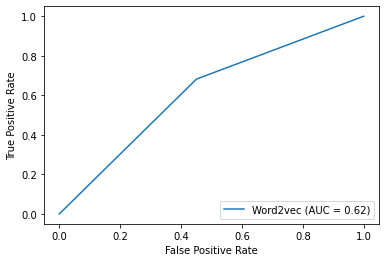

In [26]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_test[:10000]
prevs = predict(model, X_test_np.values[:10000], verbose1 = False, verbose2 = True)

#accuracy
accuracy = accuracy_score(trs, prevs)
print('accuracy: {}'.format(accuracy))

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

#roc curve
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(trs, prevs)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Word2vec')
display.plot()
plt.show()

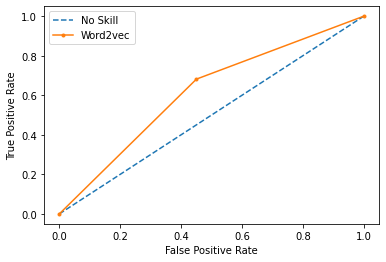

In [33]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr, tpr, thresholds = metrics.roc_curve(trs, prevs)

#generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(trs))]

#predict probabilities
#prevs = prevs[:, 1]

#roc curve
ns_fpr, ns_tpr, _ = roc_curve(trs, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(trs, prevs)

#plot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Word2vec')

#axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

#legend
pyplot.legend()

pyplot.show()